In [1]:
import numpy as np
import zarr
from scipy import interpolate
from msi_zarr_analysis.utils import iter_chunks
import matplotlib.pyplot as plt
import time

In [2]:
region13 = zarr.open_group("../datasets/comulis13.zarr/", mode='r')

In [3]:
def interpolate_spectrum(s_mzs: np.ndarray, s_int: np.ndarray, new_mzs_axis: np.ndarray) -> np.ndarray:
    interpolate_fn = interpolate.interp1d(
        s_mzs,
        s_int,
        kind="linear",
        copy=False,  # s_mzs and s_int are only used once
        bounds_error=False, # the new axis goes further
        fill_value=0,  # --> use a 0 fill to indicate the absence of data
        assume_sorted=True,  # both are sorted
    )
    return interpolate_fn(new_mzs_axis)

In [4]:
def sum_spectra_chunk(
    c_len: np.ndarray,
    c_mzs: np.ndarray,
    c_int: np.ndarray,
    new_mzs_axis: np.ndarray,
):

    average = np.zeros(shape=new_mzs_axis.shape, dtype=c_int.dtype)
    number = 0
    
    for y, x in zip(*np.nonzero(c_len)):
        s_len = c_len[y, x]
        s_mzs = c_mzs[:s_len, y, x]
        s_int = c_int[:s_len, y, x]
        
        i_int = interpolate_spectrum(s_mzs, s_int, new_mzs_axis)

        average += i_int
        number += 1

    return average, number

In [5]:
def average_spectra_zarr(
    dataset: zarr.Group,
    new_mzs_axis: np.ndarray,
) -> np.ndarray:
    start = time.time()
    
    z_int = dataset["/0"]
    z_mzs = dataset["/labels/mzs/0"]
    z_len = dataset["/labels/lengths/0"]

    average = np.zeros(shape=new_mzs_axis.shape, dtype=z_int.dtype)
    number = 0
    
    for cy, cx in iter_chunks.iter_loaded_chunks(z_int, skip=2):
        print(f"{cy=} {cx=}")
        c_len = z_len[0, 0, cy, cx]
        c_len_max = c_len.max()
        c_mzs = z_mzs[:c_len_max, 0, cy, cx]
        c_int = z_int[:c_len_max, 0, cy, cx]
        
        c_average, c_number = sum_spectra_chunk(c_len, c_mzs, c_int, new_mzs_axis)
        
        average += c_average
        number += c_number
    
    average /= number
    
    duration = time.time() - start
    print(f"{duration=}")
    
    return average

In [6]:
new_mzs_axis = np.linspace(100, 1150, num=int(1e7))

In [7]:
avg_spectra = average_spectra_zarr(region13, new_mzs_axis)

cy=slice(588, 609, None) cx=slice(528, 552, None)
cy=slice(609, 630, None) cx=slice(384, 408, None)
cy=slice(609, 630, None) cx=slice(408, 432, None)
cy=slice(609, 630, None) cx=slice(432, 456, None)
cy=slice(609, 630, None) cx=slice(456, 480, None)
cy=slice(609, 630, None) cx=slice(480, 504, None)
cy=slice(609, 630, None) cx=slice(504, 528, None)
cy=slice(609, 630, None) cx=slice(528, 552, None)
cy=slice(609, 630, None) cx=slice(552, 576, None)
cy=slice(609, 630, None) cx=slice(576, 600, None)
cy=slice(609, 630, None) cx=slice(600, 624, None)
cy=slice(609, 630, None) cx=slice(624, 648, None)
cy=slice(609, 630, None) cx=slice(648, 672, None)
cy=slice(609, 630, None) cx=slice(744, 758, None)
cy=slice(630, 644, None) cx=slice(384, 408, None)
cy=slice(630, 644, None) cx=slice(408, 432, None)
cy=slice(630, 644, None) cx=slice(432, 456, None)
cy=slice(630, 644, None) cx=slice(456, 480, None)
cy=slice(630, 644, None) cx=slice(480, 504, None)
cy=slice(630, 644, None) cx=slice(504, 528, None)


In [49]:
avg_spectra.size, np.count_nonzero(avg_spectra)

(10000000, 9933334)

In [55]:
mask = avg_spectra > 5e6

In [56]:
np.count_nonzero(mask)

145

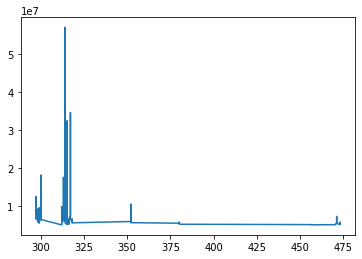

In [57]:
plt.plot(new_mzs_axis[mask], avg_spectra[mask])

(317.175, 317.178)

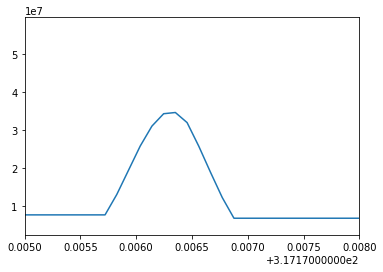

In [59]:
plt.plot(new_mzs_axis[mask], avg_spectra[mask])
plt.xlim(317.175, 317.178)

In [10]:
np.savez("save_avg_spectra.npz", avg_mzs=new_mzs_axis, avg_int=avg_spectra)